# Pipelines in Scikit Learn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score

sns.set(style="whitegrid")

In [2]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

print("Dataset shape:", X.shape)
X.head()

Dataset shape: (569, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Basic Pipeline with PCA

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5)),
    ('model', LogisticRegression(max_iter=2000))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print("Pipeline Accuracy:", accuracy_score(y_test, y_pred))


Pipeline Accuracy: 0.9883040935672515


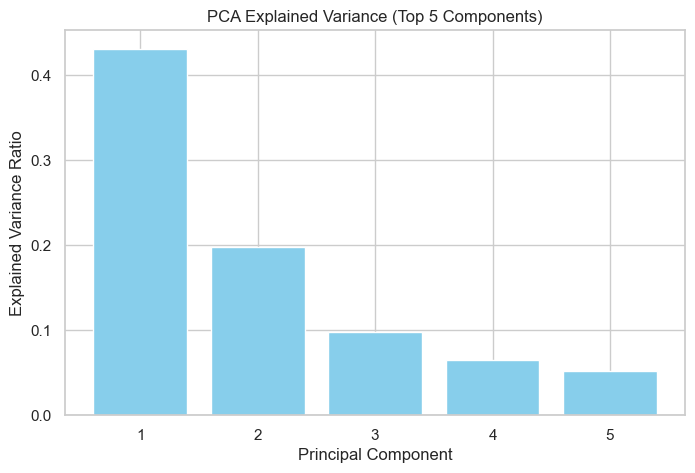

In [4]:
pca_model = pipe.named_steps['pca']
plt.figure(figsize=(8,5))
plt.bar(range(1, 6), pca_model.explained_variance_ratio_, color='skyblue')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance (Top 5 Components)')
plt.show()

## Comparison of Pipeline Models

C:\Users\ASUS\AppData\Local\Temp\ipykernel_1164\3237781554.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Logistic Regression", "Random Forest"], y=[acc_lr, acc_rf], palette="mako")


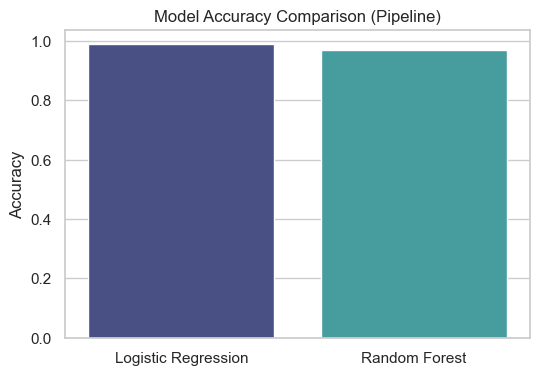

In [ ]:
rf_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(n_estimators=200, random_state=42))
])

rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_test)

acc_lr = accuracy_score(y_test, y_pred)
acc_rf = accuracy_score(y_test, y_pred_rf)

plt.figure(figsize=(6,4))
sns.barplot(x=["Logistic Regression", "Random Forest"], y=[acc_lr, acc_rf], palette="mako")
plt.title("Model Accuracy Comparison (Pipeline)")
plt.ylabel("Accuracy")
plt.show()

## ColumnTransformer + Pipeline

In [7]:
from sklearn.preprocessing import OneHotEncoder

X_mixed = X.copy()
X_mixed["mean radius_cat"] = pd.cut(X_mixed["mean radius"], bins=3, labels=["Low", "Medium", "High"])

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_mixed, y, test_size=0.3, random_state=42)

numeric_features = X.columns
categorical_features = ["mean radius_cat"]

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

full_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=3000))
])

full_pipe.fit(X_train_m, y_train_m)
y_pred_m = full_pipe.predict(X_test_m)
print("Advanced Pipeline Accuracy:", accuracy_score(y_test_m, y_pred_m))


Advanced Pipeline Accuracy: 0.9883040935672515


## Pipeline + GridSearchCV

In [8]:
pipe_gs = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=3000))
])

param_grid = {
    'model__C': [0.1, 1, 10],
    'model__solver': ['liblinear', 'lbfgs']
}

grid = GridSearchCV(pipe_gs, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Accuracy (CV):", grid.best_score_)

Best Parameters: {'model__C': 0.1, 'model__solver': 'liblinear'}
Best Accuracy (CV): 0.977373417721519


## Visualization: GridSearchCV Results


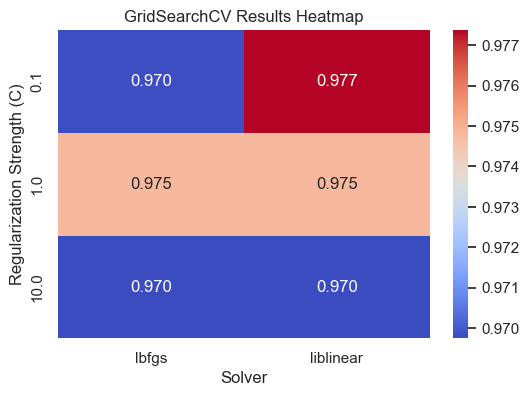

In [10]:
pivot_table = results.pivot(index="param_model__C",
                            columns="param_model__solver",
                            values="mean_test_score")

plt.figure(figsize=(6,4))
sns.heatmap(pivot_table, annot=True, cmap="coolwarm", fmt=".3f")
plt.title("GridSearchCV Results Heatmap")
plt.xlabel("Solver")
plt.ylabel("Regularization Strength (C)")
plt.show()
